In [4]:
import os
import glob
from pathlib import Path
import polars as pl
import re
import gzip
import sys
import random
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from lxml import etree, objectify

sys.path.append('../infineac/')
import file_loader
import helper

%load_ext autoreload
%autoreload 2

PATH_DIR = "../data/transcripts/"
random.seed(111)

/Users/Foal/miniconda3/envs/infineac/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/Foal/miniconda3/envs/infineac/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/Foal/miniconda3/envs/infineac/lib/python3.11/site-packages/

In [2]:
from bertopic import BERTopic

## Load Files

Load all xml files from the given directory and return a list of corresponding events.

In [32]:
files = list(Path(PATH_DIR).rglob("*.xml"))
events = file_loader.load_files_from_xml(files[0:1000])

Only consider events that are held after 2022.

In [33]:
events_filt = [event for event in events if "date" in event.keys() and event['action'] == 'publish' and event['date'].year >= 2022 and event['version'] == "Final"]

In [34]:
file = [event['file'] for event in events_filt]
id = [event['id'] for event in events_filt]
year_upload = [event['year_upload'] for event in events_filt]
company = [event['company_name'] for event in events_filt]
ticker = [event['company_ticker'] for event in events_filt]
ticker_new = [re.sub('\\..*', '', t) for t in ticker]
dates = [event['date'] for event in events_filt if "date" in event.keys()]
numeric_values = mdates.date2num(dates)

russia_and_sanction = [helper.get_russia_and_sanction(event['body_orig']) for event in events_filt]
election = [helper.get_elections(event['body_orig']) for event in events_filt]
russia_count = [event['body_orig'].lower().count('russia') for event in events_filt]
sanction_count = [event['body_orig'].lower().count('sanction') for event in events_filt]

In [36]:
events_russia = [event for event in events_filt if event['body_orig'].lower().count('russia') >= 1 or event['body_orig'].lower().count('ukraine') >= 1]
len(events_russia)

248

In [43]:
events_ukr = [event for event in events_filt if event['body_orig'].lower().count('russia') == 0 and event['body_orig'].lower().count('ukraine') >= 2]

In [61]:
events_russia = [event for event in events_filt if event['qa_collapsed'].lower().count('russia') >= 1 or event['qa_collapsed'].lower().count('ukraine') >= 1]
len(events_russia)

144

In [58]:
import preprocess_string as ps

In [65]:
print(ps.extract_parts_from_presentation(events_russia[4]['presentation'], ['russia', 'ukraine']))

 On a per active frac crew basis, our Q2 annualized revenue of 33% above that of 2018, which was the peak of the North America shale market. While our European chemical business was impacted by a supply chain disruption due to the Russia/Ukraine conflict, the overall segment still achieved 24% adjusted EBITDA margins as the offshore and deepwater markets continue to show signs of a multiyear growth cycle, supported by a forecasted 5-year high in subsea tree orders in 2022.
 The brine fluid test results from our territory well are very encouraging, with both lithium and bromine concentrations above the values used by an independent study for the exploration target report values that we announced last year.
 Overall, our second quarter revenue grew 8% from the first quarter of 2022 and 38% from the second quarter of 2021. Adjusted EBITDA of $18.7 million decreased $1.8 million sequentially and was negatively impacted by $2 million of charges, which included $1.3 million unfavorable impac

In [70]:
print(ps.extract_parts_from_qa(events_russia[4]['qa'], ['russia', 'ukraine']))

Sure. Yes, I appreciate that. Obviously, it's a pretty fluid situation. And the Ukraine/Russia conflict came up fairly suddenly and caught us all a little bit off guard as you can imagine. We're fortunate that, yes, there are other supplies. This is a commodity. But as you're probably aware, global commodities, even in today's environment, are pretty tight. So it's just not an immediate replacement.
 We were encouraged with the production volumes that they are now projected for the third quarter, but it's still not to the full levels that we need. We think ultimately, this will get solved, but we don't have perfect visibility right now into exactly when we can anticipate that.



In [10]:
# import dill as pickle
# pickle.dump(events_russia, open('../output/pickled/events_russia.pkl', 'wb'))
# pickle.dump(events, open('../output/pickled/events.pkl', 'wb'))

Create a DataFrame with the following columns and save it as a csv file:

In [7]:
df = pd.DataFrame({'file': file,
                   'year_upload': year_upload,
                   'company': company,
                   'ticker':ticker,
                   'ticker_new': ticker_new,
                   'date': dates,
                   'dates_num' : numeric_values,
                   'russia': russia_and_sanction,
                   'russia_count': russia_count,
                   'sanction_count': sanction_count,
                   'election': election})

In [6]:
docs = [event['presentation_collapsed'] + "\n" + event['qa_collapsed'] for event in events_russia]

In [7]:
topics, probs = helper.bert_basic(docs[0:500])

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


: 

: 

In [6]:
df.to_csv('../output/data/overview.csv', index=False)

In [7]:
#  df[['company', 'ticker', 'ticker_new', 'date', 'russia', 'russia_count', 'sanction_count']].to_csv('../output/data/overview_jakob.csv', index=False)
# with open('../output/data/overview_jakob.csv', 'rb') as f_in:
#     with gzip.open('../output/data/overview_jakob.csv.gz', 'wb') as f_out:
#         shutil.copyfileobj(f_in, f_out)

Create 15 samples for each category: russia and election and save it in the
corresponding directory.

In [8]:
if len(df[df['russia'] == 'russia & sanctions']) >0:sample_files_russia = df[df['russia'] == 'russia'].sample(8)['file'].tolist() + df[df['russia'] == 'russia & sanctions'].sample(7)['file'].tolist()
if len(df[df['election'] == 'presidential election']) >0: sample_files_election = df[df['election'] == 'presidential election'].sample(15)['file'].tolist()

In [9]:
# delete all files in folder
if 'sample_files_russia' in locals() or 'sample_files_russia' in globals():
    folder = '../output/sample transcripts/russia/'
    files = os.listdir(folder)
    for f in files:
        os.remove(folder + f)
    # copy sample files to folder
    for file in sample_files_russia:
        shutil.copy(file, folder)

In [10]:
# delete all files in folder
if 'sample_files_election' in locals() or sample_files_election in globals():
    folder = '../output/sample transcripts/election/'
    files = os.listdir(folder)
    for f in files:
        os.remove(folder + f)
    # copy sample files to folder
    for file in sample_files_election:
        shutil.copy(file, folder)

## Figures

Count the number of occasions where the word "russia" (and "sanction") appears in the earnings call.

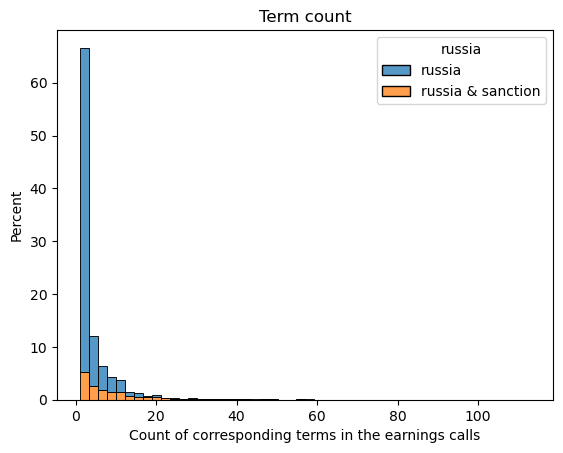

In [11]:
sns.histplot(df[df['russia_count']>=1], x='russia_count', hue="russia", bins=50, stat="percent", common_norm=True, multiple="stack")
plt.xlabel('Count of corresponding terms in the earnings calls')
plt.ylabel('Percent')
plt.title('Term count')
plt.show()

Average mentions of "russia" per earnings call.

In [12]:
np.array(russia_count).mean()

0.7839888358197221

Average mentions of "russia" per earnings call if "russia" is mentioned at
least once.

In [13]:
np.array([el for el in russia_count if el > 0]).mean()

4.389940567906669

Average mentions of "sanction" per earnings call.

In [14]:
np.array([event['body_orig'].lower().count('sanction') for event in events]).mean()

0.11202293006670876

Event distribution over time highlighting the different categories.

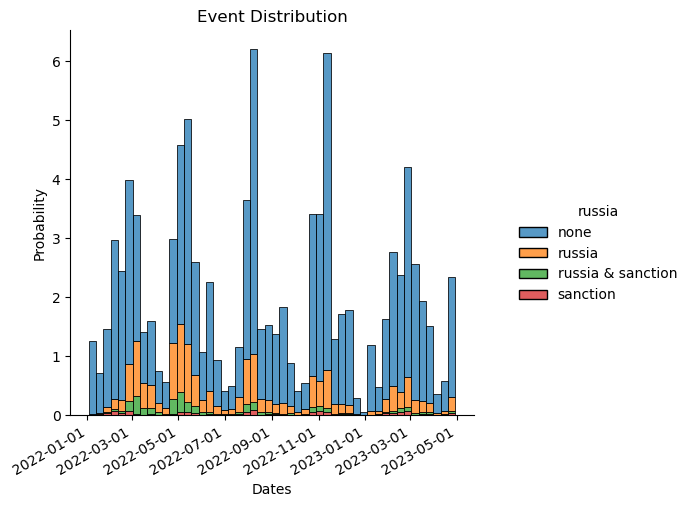

In [15]:
# plt.hist(numeric_values, bins=50)
# sns.histplot(numeric_values, bins=50)
sns.displot(df, x="dates_num", hue="russia", bins=50, stat="percent", common_norm=True, multiple="stack")
# plt.plot_date(dates, numeric_values, '-o')  # '-o' adds markers on the data points
plt.xlabel('Dates')
plt.ylabel('Probability')
plt.title('Event Distribution')

# Add x-axis ticks and labels
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Customize date format as needed

plt.gcf().autofmt_xdate()  # Adjusts the date labels rotation for better visibility

plt.show()

Event proportion over time highlighting the different categories.

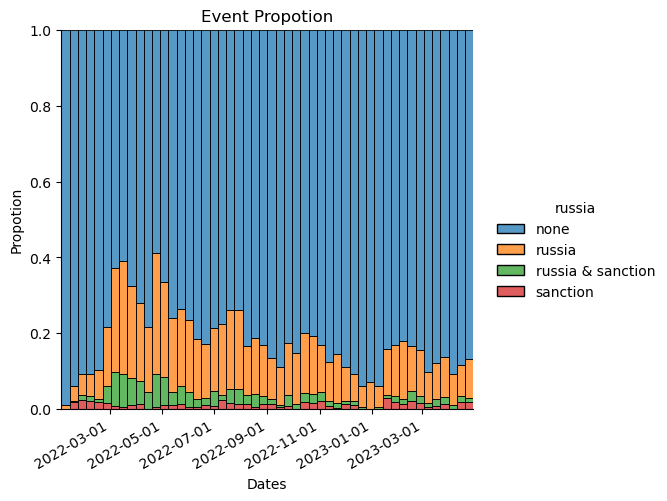

In [16]:
# plt.hist(numeric_values, bins=50)
# sns.histplot(numeric_values, bins=50)
sns.displot(df, x="dates_num", hue="russia", bins=50, stat="proportion", common_norm=True, multiple="fill")
# plt.plot_date(dates, numeric_values, '-o')  # '-o' adds markers on the data points
plt.xlabel('Dates')
plt.ylabel('Propotion')
plt.title('Event Propotion')

# Add x-axis ticks and labels
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Customize date format as needed

plt.gcf().autofmt_xdate()  # Adjusts the date labels rotation for better visibility

plt.show()

Polars

In [5]:
keys_to_keep = ['file', 'body_orig']

In [8]:
events_new_trimmed = [{key: event[key] for key in keys_to_keep} for event in events_new]

In [9]:
eventsDF = pl.from_dicts(events_new_trimmed)

In [28]:
eventsDF = eventsDF.with_columns(pl.col("body_orig").str.count_match('(E|e)lections').alias("elections_count"))
eventsDF = eventsDF.with_columns(pl.col("body_orig").str.count_match('(S|s)anctions').alias("sanctions_count"))
eventsDF = eventsDF.with_columns(pl.col("body_orig").str.count_match('(R|r)ussia').alias("russia_count"))

In [37]:
len(eventsDF.filter(pl.col("elections_count") > 0))

1535

In [36]:
len(eventsDF.filter((pl.col("sanctions_count") > 0) & (pl.col("russia_count") > 0)))

1533

In [7]:
file = "../data/Transcripts/2022/15232031_T.xml"

In [14]:
for _, elem in etree.iterparse(file):
            tag = elem.tag
            if tag is not None:
                text = elem.text
                if tag == "Body":
                    break

In [54]:
for event, elem in etree.iterparse(file):
    if elem is not None:
        print(elem.tag)

Headline
Body
EventStory
eventTitle
city
companyName
companyTicker
startDate
Event
